## Import Packages

In [1]:
import os
import torch
import torch.backends.cudnn as cudnn
import numpy as np
from data import cfg_mnet, cfg_re50
from layers.functions.prior_box import PriorBox
from utils.nms.py_cpu_nms import py_cpu_nms
import cv2
from models.retinaface import RetinaFace
from utils.box_utils import decode, decode_landm
from utils.timer import Timer

## Utils Functions

In [2]:
from itertools import product as product
import numpy as np
from math import ceil


class PriorBox(object):
    def __init__(self, image_size=None, phase='train'):
        super(PriorBox, self).__init__()
        self.min_sizes = [[16, 32], [64, 128], [256, 512]]
        self.steps = [8, 16, 32]
        self.clip = False
        self.image_size = image_size
        self.feature_maps = [[ceil(self.image_size[0]/step), ceil(self.image_size[1]/step)] for step in self.steps]
        self.name = "s"

    def forward(self):
        anchors = []
        for k, f in enumerate(self.feature_maps):
            min_sizes = self.min_sizes[k]
            for i, j in product(range(f[0]), range(f[1])):
                for min_size in min_sizes:
                    s_kx = min_size / self.image_size[1]
                    s_ky = min_size / self.image_size[0]
                    dense_cx = [x * self.steps[k] / self.image_size[1] for x in [j + 0.5]]
                    dense_cy = [y * self.steps[k] / self.image_size[0] for y in [i + 0.5]]
                    for cy, cx in product(dense_cy, dense_cx):
                        anchors += [cx, cy, s_kx, s_ky]

        # back to torch land
        #output = torch.Tensor(anchors).view(-1, 4)
        output = np.array(anchors).reshape(-1, 4)
        if self.clip:
            output.clamp_(max=1, min=0)
        return output

In [3]:
def check_keys(model, pretrained_state_dict):
    ckpt_keys = set(pretrained_state_dict.keys())
    model_keys = set(model.state_dict().keys())
    used_pretrained_keys = model_keys & ckpt_keys
    unused_pretrained_keys = ckpt_keys - model_keys
    missing_keys = model_keys - ckpt_keys
    print('Missing keys:{}'.format(len(missing_keys)))
    print('Unused checkpoint keys:{}'.format(len(unused_pretrained_keys)))
    print('Used keys:{}'.format(len(used_pretrained_keys)))
    assert len(used_pretrained_keys) > 0, 'load NONE from pretrained checkpoint'
    return True

In [4]:
def decode(loc, priors, variances):
    """Decode locations from predictions using priors to undo
    the encoding we did for offset regression at train time.
    Args:
        loc (tensor): location predictions for loc layers,
            Shape: [num_priors,4]
        priors (tensor): Prior boxes in center-offset form.
            Shape: [num_priors,4].
        variances: (list[float]) Variances of priorboxes
    Return:
        decoded bounding box predictions
    """

    boxes = np.concatenate((
        priors[:, :2] + loc[:, :2] * variances[0] * priors[:, 2:],
        priors[:, 2:] * np.exp(loc[:, 2:] * variances[1])), 1)
    boxes[:, :2] -= boxes[:, 2:] / 2
    boxes[:, 2:] += boxes[:, :2]
    return boxes

In [5]:
def decode_landm(pre, priors, variances):
    """Decode landm from predictions using priors to undo
    the encoding we did for offset regression at train time.
    Args:
        pre (tensor): landm predictions for loc layers,
            Shape: [num_priors,10]
        priors (tensor): Prior boxes in center-offset form.
            Shape: [num_priors,4].
        variances: (list[float]) Variances of priorboxes
    Return:
        decoded landm predictions
    """
    landms = np.concatenate((priors[:, :2] + pre[:, :2] * variances[0] * priors[:, 2:],
                        priors[:, :2] + pre[:, 2:4] * variances[0] * priors[:, 2:],
                        priors[:, :2] + pre[:, 4:6] * variances[0] * priors[:, 2:],
                        priors[:, :2] + pre[:, 6:8] * variances[0] * priors[:, 2:],
                        priors[:, :2] + pre[:, 8:10] * variances[0] * priors[:, 2:],
                        ), axis=1)
    return landms

In [6]:
def remove_prefix(state_dict, prefix):
    ''' Old style model is stored with all names of parameters sharing common prefix 'module.' '''
    print('remove prefix \'{}\''.format(prefix))
    f = lambda x: x.split(prefix, 1)[-1] if x.startswith(prefix) else x
    return {f(key): value for key, value in state_dict.items()}

In [7]:
def py_cpu_nms(dets, thresh):
    """Pure Python NMS baseline."""
    x1 = dets[:, 0]
    y1 = dets[:, 1]
    x2 = dets[:, 2]
    y2 = dets[:, 3]
    scores = dets[:, 4]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= thresh)[0]
        order = order[inds + 1]

    return keep

In [8]:
def load_model(model, pretrained_path, load_to_cpu):
    print('Loading pretrained model from {}'.format(pretrained_path))
    if load_to_cpu:
        pretrained_dict = torch.load(pretrained_path, map_location=lambda storage, loc: storage)
    else:
        device = torch.cuda.current_device()
        pretrained_dict = torch.load(pretrained_path, map_location=lambda storage, loc: storage.cuda(device))
    if "state_dict" in pretrained_dict.keys():
        pretrained_dict = remove_prefix(pretrained_dict['state_dict'], 'module.')
    else:
        pretrained_dict = remove_prefix(pretrained_dict, 'module.')
    check_keys(model, pretrained_dict)
    model.load_state_dict(pretrained_dict, strict=False)
    return model

## Params

In [9]:
model_path = "./models/Resnet50_Final.pth"

In [10]:
cfg_re50 = {
    'name': 'Resnet50',
    'min_sizes': [[16, 32], [64, 128], [256, 512]],
    'steps': [8, 16, 32],
    'variance': [0.1, 0.2],
    'clip': False,
    'loc_weight': 2.0,
    'gpu_train': True,
    'batch_size': 24,
    'ngpu': 4,
    'epoch': 100,
    'decay1': 70,
    'decay2': 90,
    'image_size': 840,
    'pretrain': True,
    'return_layers': {'layer2': 1, 'layer3': 2, 'layer4': 3},
    'in_channel': 256,
    'out_channel': 256
}


## load model

In [11]:
net = RetinaFace(cfg=cfg_re50, phase = 'test')
if torch.cuda.is_available():
    net = load_model(net, model_path, False)
else:
    net = load_model(net, model_path, True)
net.eval()
print('Finished loading model!')
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
net = net.to(device)

Loading pretrained model from ./models/Resnet50_Final.pth
remove prefix 'module.'
Missing keys:0
Unused checkpoint keys:0
Used keys:456
Finished loading model!


## Get Det

In [71]:
from PIL import Image
import torchvision.transforms as transforms

def getDets(imgPath ="./data/input/female/2022-01-01_440.png",new_width=512,device="cpu"):
    img = Image.open(imgPath).convert('RGB')

    concat = new_width/float(img.size[0])
    size = int((float(img.size[1])*float(concat)))
    img = img.resize((new_width,size), Image.ANTIALIAS)

    img_raw = np.array(img)
    img = np.float32(img)

    im_height, im_width, _ = img.shape
    scale = torch.Tensor([img.shape[1], img.shape[0], img.shape[1], img.shape[0]])
    img -= (104, 117, 123)
    img = img.transpose(2, 0, 1)

    img = torch.from_numpy(img).unsqueeze(0)
    img = img.to(device)
    scale = scale.to(device)
    loc, conf, landms = net(img)

    d = {
    'loc': loc,
    'conf': conf,
    'landms': landms
    }

    loc = loc.cpu().detach().numpy()
    conf = conf.cpu().detach().numpy()
    landms = landms.cpu().detach().numpy()

    priorbox = PriorBox(image_size=(im_height, im_width))
    
    priors = priorbox.forward()
    prior_data = priors
    scores = conf[0][:, 1]
    boxes = decode(loc[0], prior_data, [0.1, 0.2])
    scale = scale.cpu().detach().numpy()
    resize = 1
    boxes = boxes * scale / resize
    landms = decode_landm(landms[0], prior_data, [0.1, 0.2])
    tmp = [img.shape[3], img.shape[2], img.shape[3], img.shape[2],
                               img.shape[3], img.shape[2], img.shape[3], img.shape[2],
                               img.shape[3], img.shape[2]]
    scale1 = np.array(tmp, dtype=np.float32)
    #scale1 = scale1.to(device)
    landms = landms * scale1 / resize
    # ignore low scores
    inds = np.where(scores > 0.02)[0]
    boxes = boxes[inds]
    landms = landms[inds]
    scores = scores[inds]

    # keep top-K before NMS
    #order = scores.argsort()[::-1][:5000]
    order = scores.argsort()[::-1]
    boxes = boxes[order]
    landms = landms[order]
    scores = scores[order]
    # do NMS
    dets = np.hstack((boxes, scores[:, np.newaxis])).astype(np.float32, copy=False)
    bounding_boxes = np.hstack((boxes, scores[:, np.newaxis])).astype(np.float32, copy=False)
    keep = py_cpu_nms(dets, 0.4)
    # keep = nms(dets, args.nms_threshold,force_cpu=args.cpu)
    dets = dets[keep, :]
    bounding_boxes = bounding_boxes[keep, :]

    landms = landms[keep]

    # keep top-K faster NMS
    # dets = dets[:750, :]
    # landms = landms[:750, :]

    dets = np.concatenate((dets, landms), axis=1)
    bboxes = np.concatenate((bounding_boxes, landms), axis=1)
    return img_raw, dets[0]

## Inference

In [72]:
def Relcrop(image, b,factors=(0.3,0.2,0.15,0.15)):
    landmarks_top = b[1]
    landmarks_bottom = b[3]
    landmarks_left = b[0]
    landmarks_right = b[2]
    top = int(landmarks_top - factors[0] * (landmarks_bottom - landmarks_top))
    bottom = int(landmarks_bottom + factors[1] * (landmarks_bottom - landmarks_top))
    left = int(landmarks_left - factors[2] * (landmarks_right - landmarks_left))
    right = int(landmarks_right + factors[3] * (landmarks_right - landmarks_left))
    
    if bottom - top > right - left:
        left -= ((bottom - top) - (right - left)) // 2
        right = left + (bottom - top)
    else:
        top -= ((right - left) - (bottom - top)) // 2
        bottom = top + (right - left)
    image_crop = np.ones(
        (bottom - top + 1, right - left + 1, 3), np.uint8) * 255
    h, w = image.shape[:2]
    left_white = max(0, -left)
    left = max(0, left)
    right = min(right, w-1)
    right_white = left_white + (right-left)
    top_white = max(0, -top)
    top = max(0, top)
    bottom = min(bottom, h-1)
    bottom_white = top_white + (bottom - top)

    image_crop[top_white:bottom_white+1, left_white:right_white +
                1] = image[top:bottom+1, left:right+1].copy()
    return image_crop

In [108]:
img_raw,dets = getDets("./data/input/Good/3.jpeg",512)
image_crop = Relcrop(img_raw, dets)
face_crop = Relcrop(img_raw,dets,(0,0,0,0))

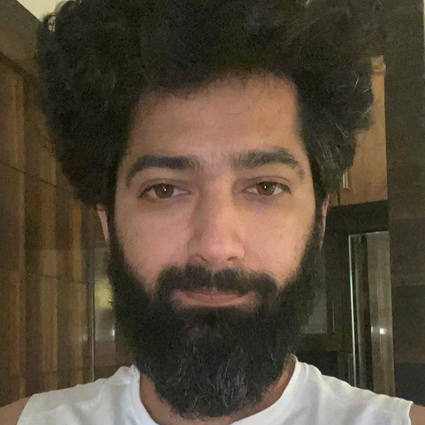

In [103]:
Image.fromarray(image_crop)

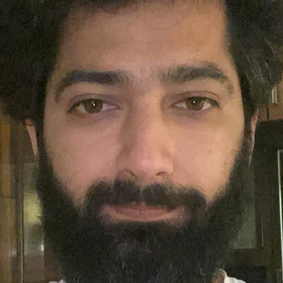

In [104]:
Image.fromarray(face_crop)

In [98]:
face_crop.shape

(105, 105, 3)